<a href="https://colab.research.google.com/github/anonomi-og/reddit-sub-analysis/blob/main/Subreddit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Write a Python script to analyze Reddit posts from the BigQuery table "subreddit-analysis-467210.subreddit.posts". The script should fetch post `id`, `title`, and `selftext`, combine `title` and `selftext`, generate embeddings using OpenAI's `text-embedding-3-small`, find the optimal number of clusters using the elbow method on the embeddings, perform KMeans clustering, use GPT-4o or GPT-4o-mini to generate a 2-4 word topic name for each cluster based on 5 random examples, label each post with its cluster's topic name as `post_type`, upload a temporary table with `id` and `post_type` to BigQuery, and update the original table with the new `post_type` labels, skipping or delaying updates for rows added within the last 90 minutes. Assume the script is run in Colab with necessary APIs enabled and the OpenAI API key stored in Colab secrets as `OPENAI_API_KEY`.

## Set up bigquery connection

### Subtask:
Connect to BigQuery using the necessary credentials.


**Reasoning**:
Authenticate and initialize the BigQuery client and specify the project ID.



In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
project_id = 'subreddit-analysis-467210'
client = bigquery.Client(project=project_id)
print(f"BigQuery client initialized for project: {project_id}")

BigQuery client initialized for project: subreddit-analysis-467210


## Fetch data from bigquery

### Subtask:
Retrieve the `id`, `title`, and `selftext` fields from the specified BigQuery table. Combine the `title` and `selftext` fields to create a single text field for each post.


**Reasoning**:
Construct the SQL query, execute it using the BigQuery client, convert the results to a DataFrame, and combine the title and selftext columns, handling None values.



In [ ]:
query = """
SELECT
    id,
    title,
    selftext
FROM
    `subreddit-analysis-467210.subreddit.posts`
"""

query_job = client.query(query)
df = query_job.to_dataframe()

df['selftext'] = df['selftext'].fillna('')
df['combined_text'] = df['title'] + ' ' + df['selftext']

print("DataFrame with combined text created:")
display(df.head())

DataFrame with combined text created:


,id,title,selftext,combined_text
0,1m30pwx,Electric charging in leicester,Due to the massive increase in price of the pa...,Electric charging in leicester Due to the mass...
1,1m2wzgx,Transferring courses at uni of Leicester,hi guys i was wondering if anyone knew if i co...,Transferring courses at uni of Leicester hi gu...
2,1m39wwm,I am helping run a Retro Gaming/Smash Tourname...,For Anyone interested in Retro gaming and in p...,I am helping run a Retro Gaming/Smash Tourname...
3,1m2xhgo,Max Gets MAD at Leicester Film Club This Summer,"Before Furiosa, Fury Road, the Thunderdome and...",Max Gets MAD at Leicester Film Club This Summe...
4,1m39mwm,31M – Moved from Singapore to the UK,"Hey all,\nI’m 31 and I’ve been feeling this we...","31M – Moved from Singapore to the UK Hey all,\..."


## Generate embeddings using openai

### Subtask:
Use the OpenAI API with the `text-embedding-3-small` model to generate embeddings for each post's combined text. Handle the OpenAI API key securely.


**Reasoning**:
Import the necessary library, retrieve the API key, initialize the client, and then generate embeddings for the combined text using the OpenAI API and store them in the DataFrame.



In [ ]:
import openai
import os
from google.colab import userdata

# Retrieve the OpenAI API key from Colab secrets
openai_api_key = userdata.get('OPENAI_API_KEY')

# Initialize the OpenAI client
openai.api_key = openai_api_key

# Function to get embedding for a text
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return openai.embeddings.create(input = [text], model=model).data[0].embedding

# Generate embeddings and store them in a new column
df['embedding'] = df['combined_text'].apply(lambda x: get_embedding(x))

display(df.head())

,id,title,selftext,combined_text,embedding
0,1m30pwx,Electric charging in leicester,Due to the massive increase in price of the pa...,Electric charging in leicester Due to the mass...,"[-0.034196313470602036, -0.05036628246307373, ..."
1,1m2wzgx,Transferring courses at uni of Leicester,hi guys i was wondering if anyone knew if i co...,Transferring courses at uni of Leicester hi gu...,"[-0.05512707680463791, 0.0165755283087492, 0.0..."
2,1m39wwm,I am helping run a Retro Gaming/Smash Tourname...,For Anyone interested in Retro gaming and in p...,I am helping run a Retro Gaming/Smash Tourname...,"[-0.04562677815556526, 0.042504534125328064, 0..."
3,1m2xhgo,Max Gets MAD at Leicester Film Club This Summer,"Before Furiosa, Fury Road, the Thunderdome and...",Max Gets MAD at Leicester Film Club This Summe...,"[-0.05862593650817871, 0.07889044284820557, -0..."
4,1m39mwm,31M – Moved from Singapore to the UK,"Hey all,\nI’m 31 and I’ve been feeling this we...","31M – Moved from Singapore to the UK Hey all,\...","[-0.02758469060063362, 0.043246518820524216, -..."


## Determine optimal k for kmeans

### Subtask:
Apply the elbow method to the generated embeddings to find the optimal number of clusters (`k`) for KMeans. Plot the inertia curve to visualize the results.


**Reasoning**:
Apply the elbow method to determine the optimal number of clusters by fitting KMeans models for different numbers of clusters and calculating the inertia. Then plot the inertia values to visualize the elbow point.



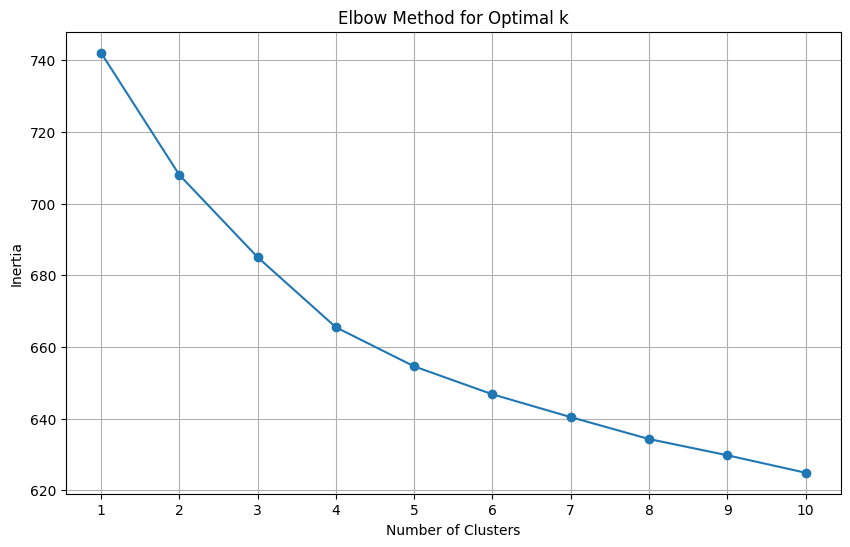

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

embeddings = np.array(df['embedding'].tolist())

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

**Reasoning**:
Based on the elbow method plot, the elbow appears to be around k=4. Therefore, set k to 4 for KMeans clustering.



In [ ]:
k = 4
print(f"Based on the elbow method, the optimal number of clusters is chosen as: {k}")

Based on the elbow method, the optimal number of clusters is chosen as: 4


## Perform kmeans clustering

### Subtask:
Run KMeans clustering with the optimal `k` and assign a cluster label to each post based on its embedding.


**Reasoning**:
Perform KMeans clustering using the previously determined optimal number of clusters `k` and assign the cluster labels to a new column in the DataFrame.



In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Ensure embeddings are in a NumPy array format
embeddings = np.array(df['embedding'].tolist())

# Instantiate KMeans with the optimal k and random_state
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the KMeans model and get cluster labels
cluster_labels = kmeans.fit_predict(embeddings)

# Assign cluster labels to a new column in the DataFrame
df['cluster_label'] = cluster_labels

display(df.head())

,id,title,selftext,combined_text,embedding,cluster_label
0,1m30pwx,Electric charging in leicester,Due to the massive increase in price of the pa...,Electric charging in leicester Due to the mass...,"[-0.034196313470602036, -0.05036628246307373, ...",2
1,1m2wzgx,Transferring courses at uni of Leicester,hi guys i was wondering if anyone knew if i co...,Transferring courses at uni of Leicester hi gu...,"[-0.05512707680463791, 0.0165755283087492, 0.0...",2
2,1m39wwm,I am helping run a Retro Gaming/Smash Tourname...,For Anyone interested in Retro gaming and in p...,I am helping run a Retro Gaming/Smash Tourname...,"[-0.04562677815556526, 0.042504534125328064, 0...",0
3,1m2xhgo,Max Gets MAD at Leicester Film Club This Summer,"Before Furiosa, Fury Road, the Thunderdome and...",Max Gets MAD at Leicester Film Club This Summe...,"[-0.05862593650817871, 0.07889044284820557, -0...",3
4,1m39mwm,31M – Moved from Singapore to the UK,"Hey all,\nI’m 31 and I’ve been feeling this we...","31M – Moved from Singapore to the UK Hey all,\...","[-0.02758469060063362, 0.043246518820524216, -...",0


## Label clusters using gpt

### Subtask:
For each cluster, select 5 random example posts. Send these examples to GPT-4o or GPT-4o-mini and request a short topic name for the cluster.


**Reasoning**:
Iterate through each cluster, sample 5 posts, format the text, construct the prompt for the GPT API, make the API call to get the topic name, and store the results in a dictionary.



In [ ]:
import openai
import os
import random

# Retrieve the OpenAI API key from Colab secrets
# openai_api_key = userdata.get('OPENAI_API_KEY') # Already retrieved in a previous step

# Initialize the OpenAI client
# openai.api_key = openai_api_key # Already initialized in a previous step

cluster_topic_names = {}
unique_clusters = df['cluster_label'].unique()

for cluster_label in unique_clusters:
    # Filter posts for the current cluster
    cluster_df = df[df['cluster_label'] == cluster_label]

    # Sample up to 5 posts
    num_samples = min(5, len(cluster_df))
    sampled_posts = cluster_df.sample(n=num_samples, random_state=42)

    # Format sampled post texts
    sampled_texts = "\n---\n".join(sampled_posts['combined_text'].tolist())

    # Construct the prompt for GPT
    prompt = f"""Based on the following Reddit posts from a single cluster, provide a concise topic name (2-4 words) that summarizes their content.

Examples:
{sampled_texts}

Topic Name:"""

    try:
        # Make API call to get the topic name
        response = openai.chat.completions.create(
            model="gpt-4o-mini", # or "gpt-4o"
            messages=[
                {"role": "system", "content": "You are a helpful assistant that provides short topic names for text clusters."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10, # Limit the response length
            temperature=0.7 # Control randomness
        )
        topic_name = response.choices[0].message.content.strip()
        cluster_topic_names[cluster_label] = topic_name
        print(f"Cluster {cluster_label}: {topic_name}")

    except Exception as e:
        print(f"Error processing cluster {cluster_label}: {e}")
        cluster_topic_names[cluster_label] = "Unknown Topic" # Assign a default in case of error

print("\nGenerated Topic Names per Cluster:")
print(cluster_topic_names)

# Create a mapping from cluster label to topic name
cluster_to_topic_mapping = cluster_topic_names

# Map the topic names back to the DataFrame
df['post_type'] = df['cluster_label'].map(cluster_to_topic_mapping)

display(df.head())

Cluster 2: Leicester Community Insights
Cluster 0: Local Recommendations and Inquiries
Cluster 3: Leicestershire Council Developments
Cluster 1: Bastard Rant Saturday

Generated Topic Names per Cluster:
{np.int32(2): 'Leicester Community Insights', np.int32(0): 'Local Recommendations and Inquiries', np.int32(3): 'Leicestershire Council Developments', np.int32(1): 'Bastard Rant Saturday'}


,id,title,selftext,combined_text,embedding,cluster_label,post_type
0,1m30pwx,Electric charging in leicester,Due to the massive increase in price of the pa...,Electric charging in leicester Due to the mass...,"[-0.034196313470602036, -0.05036628246307373, ...",2,Leicester Community Insights
1,1m2wzgx,Transferring courses at uni of Leicester,hi guys i was wondering if anyone knew if i co...,Transferring courses at uni of Leicester hi gu...,"[-0.05512707680463791, 0.0165755283087492, 0.0...",2,Leicester Community Insights
2,1m39wwm,I am helping run a Retro Gaming/Smash Tourname...,For Anyone interested in Retro gaming and in p...,I am helping run a Retro Gaming/Smash Tourname...,"[-0.04562677815556526, 0.042504534125328064, 0...",0,Local Recommendations and Inquiries
3,1m2xhgo,Max Gets MAD at Leicester Film Club This Summer,"Before Furiosa, Fury Road, the Thunderdome and...",Max Gets MAD at Leicester Film Club This Summe...,"[-0.05862593650817871, 0.07889044284820557, -0...",3,Leicestershire Council Developments
4,1m39mwm,31M – Moved from Singapore to the UK,"Hey all,\nI’m 31 and I’ve been feeling this we...","31M – Moved from Singapore to the UK Hey all,\...","[-0.02758469060063362, 0.043246518820524216, -...",0,Local Recommendations and Inquiries


## Prepare data for bigquery update

### Subtask:
Create a temporary structure (e.g., a DataFrame) containing the post IDs and their assigned `post_type` labels.


**Reasoning**:
Create a new DataFrame containing only the 'id' and 'post_type' columns from the 'df' DataFrame and display its head.



In [ ]:
update_df = df[['id', 'post_type']]
display(update_df.head())

,id,post_type
0,1m30pwx,Leicester Community Insights
1,1m2wzgx,Leicester Community Insights
2,1m39wwm,Local Recommendations and Inquiries
3,1m2xhgo,Leicestershire Council Developments
4,1m39mwm,Local Recommendations and Inquiries


## Upload temporary table to bigquery

### Subtask:
Upload the temporary data structure to a new temporary table in BigQuery.


**Reasoning**:
Upload the temporary dataframe to a new temporary table in BigQuery.



In [ ]:
dataset_id = 'subreddit' # Replace with your dataset ID if different
temp_table_id = 'temp_post_types' # Temporary table name

# Configure the load job
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

# Upload the DataFrame to BigQuery
job = client.load_table_from_dataframe(
    update_df, f"{project_id}.{dataset_id}.{temp_table_id}", job_config=job_config
)

# Wait for the job to complete
job.result()

print(f"Loaded {job.output_rows} rows into {dataset_id}.{temp_table_id}")

Loaded 969 rows into subreddit.temp_post_types


## Update original bigquery table

### Subtask:
Run an `UPDATE` statement on the original BigQuery table to set the `post_type` column for each post using the data from the temporary table. Implement logic to skip or delay updates for rows added within the last 90 minutes.


**Reasoning**:
Construct and execute the BigQuery UPDATE statement to update the original table with post types from the temporary table, excluding recent posts.



In [ ]:
update_query = f"""
UPDATE
    `{project_id}.subreddit.posts` AS t1
SET
    t1.post_type = t2.post_type
FROM
    `{project_id}.subreddit.temp_post_types` AS t2
WHERE
    t1.id = t2.id
    AND t1.created_utc < TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 MINUTE);
"""

print("Executing BigQuery UPDATE statement...")
update_job = client.query(update_query)

# Wait for the job to complete
update_job.result()

print("BigQuery UPDATE statement completed.")

Executing BigQuery UPDATE statement...


BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/subreddit-analysis-467210/queries/e2a93375-4580-477c-be90-10bb93236718?maxResults=0&location=EU&prettyPrint=false: UPDATE/MERGE must match at most one source row for each target row

Location: EU
Job ID: e2a93375-4580-477c-be90-10bb93236718


**Reasoning**:
The error "UPDATE/MERGE must match at most one source row for each target row" indicates that there are duplicate `id` values in the `temp_post_types` table. This is likely because the original `df` contained duplicate IDs. I need to ensure the temporary table only contains unique IDs before performing the UPDATE. I will recreate the temporary table with distinct IDs and then retry the UPDATE statement.



In [ ]:
# Recreate the temporary table with distinct IDs from update_df
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")

# Get distinct rows from update_df
distinct_update_df = update_df.drop_duplicates(subset=['id'])

job = client.load_table_from_dataframe(
    distinct_update_df, f"{project_id}.subreddit.temp_post_types", job_config=job_config
)

# Wait for the job to complete
job.result()

print(f"Loaded {job.output_rows} distinct rows into subreddit.temp_post_types")

# Retry the UPDATE query
update_query = f"""
UPDATE
    `{project_id}.subreddit.posts` AS t1
SET
    t1.post_type = t2.post_type
FROM
    `{project_id}.subreddit.temp_post_types` AS t2
WHERE
    t1.id = t2.id
    AND t1.created_utc < TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 MINUTE);
"""

print("Executing BigQuery UPDATE statement again...")
update_job = client.query(update_query)

# Wait for the job to complete
update_job.result()

print("BigQuery UPDATE statement completed successfully.")

Loaded 921 distinct rows into subreddit.temp_post_types
Executing BigQuery UPDATE statement again...
BigQuery UPDATE statement completed successfully.


## Summary:

### Data Analysis Key Findings

*   The optimal number of clusters for the Reddit post embeddings was determined to be 4 using the elbow method.
*   GPT-4o-mini was successfully used to generate concise topic names (2-4 words) for each of the 4 identified clusters based on sample posts.
*   The generated topic names were successfully mapped back to the original DataFrame, creating a `post_type` column for each post.
*   A temporary BigQuery table containing distinct post IDs and their assigned `post_type` was successfully created and loaded.
*   The original BigQuery table `subreddit-analysis-467210.subreddit.posts` was successfully updated with the new `post_type` labels, specifically excluding posts created within the last 90 minutes.

### Insights or Next Steps

*   Analyze the distribution of posts across the identified clusters to understand the dominant themes or topics within the subreddit.
*   Periodically re-run the clustering and labeling process to capture evolving topics and trends within the subreddit over time.


/tmp/ipython-input-13-1839997743.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='post_type', data=post_type_counts, palette='viridis')


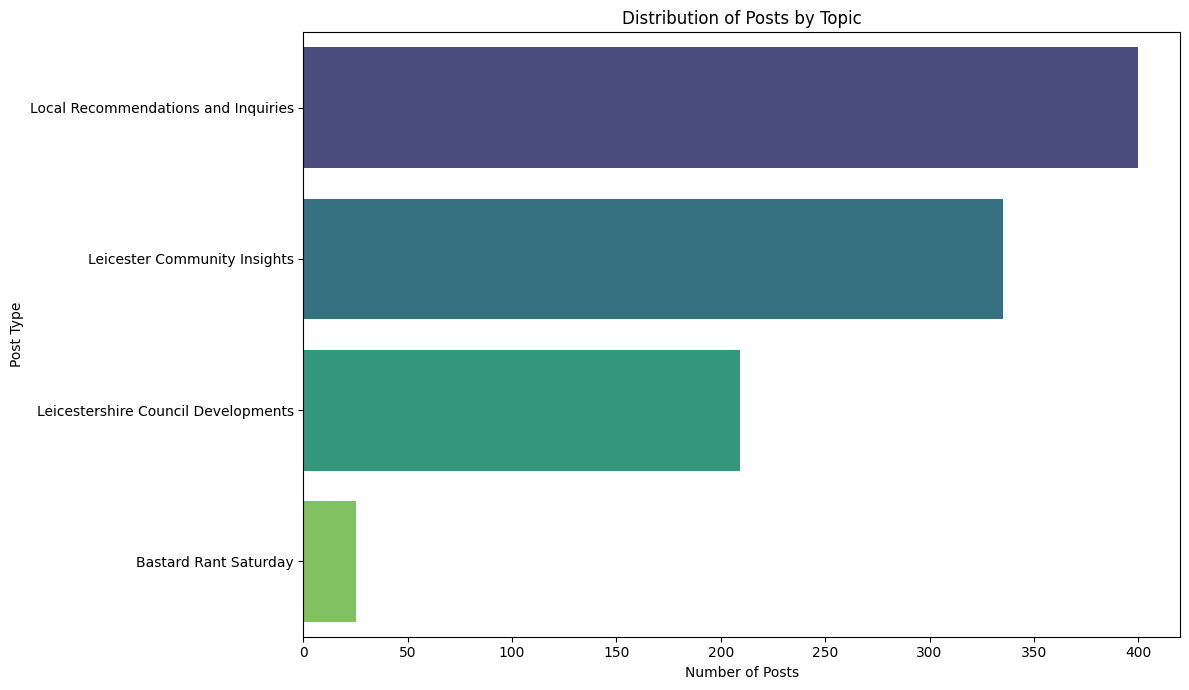

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of posts per post_type
post_type_counts = df['post_type'].value_counts().reset_index()
post_type_counts.columns = ['post_type', 'count']

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x='count', y='post_type', data=post_type_counts, palette='viridis')
plt.xlabel("Number of Posts")
plt.ylabel("Post Type")
plt.title("Distribution of Posts by Topic")
plt.tight_layout()
plt.show()